### Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

## get crypto price data

In [2]:
from TDSCoinbaseData import TDSCoinbaseData

In [58]:
import logging
logging.getLogger().setLevel(level=logging.WARNING)

btc_data = pd.read_csv('BTC-USD.csv')

<AxesSubplot:xlabel='datetime'>

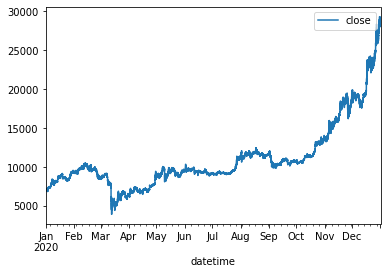

In [77]:
btc_data.head()

# set index of dataframe to be datetime column

btc_data["datetime"] = pd.to_datetime(btc_data["datetime"])
ind_btc_data = btc_data.set_index(["datetime"], drop=True)

# sorting the dataset in ascending order of date
btc_data_frame = ind_btc_data.sort_index(axis=1 ,ascending=True)
btc_data_frame.head()

#filter to just closing price
btc_df = btc_data_frame[["close"]]

#btc_df.describe()

btc_df.head()


btc_df.plot()

In [ ]:
#reading dataset
cb_obj = TDSCoinbaseData(cache_path='data', notebook_logging=True)

start_date = '20200101'
end_date = '20201231'

btc_data = cb_obj.get_market_data('BTC-USD', start_date, end_date, interval=60)
btc_data.head()

# set index of dataframe to be datetime column

ind_btc_data = btc_data.set_index(["datetime"], drop=True)

# sorting the dataset in ascending order of date
btc_data_frame = ind_btc_data.sort_index(axis=1 ,ascending=True)
btc_data_frame = btc_data_frame.iloc[::-1]
btc_data_frame.head()

#filter to just closing price
btc_df = btc_data_frame[["close"]]

btc_df.describe()

Getting BTC-USD data from 20200101 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=366)

### Train Test Split

As we have seen 80% of the data lies in the interval of 2010 and 2018 so we will train the model for the date range of **26 August 2010 to 26 August 2018** and rest will be used as the testing data

In [5]:

# we want 80% of data to go to training, 80% of year is 292 days, 292nd day is october 19th
split_date = pd.Timestamp('19-10-2020T00')


(120000, 1)
(407040, 1)
<class 'pandas.core.frame.DataFrame'>


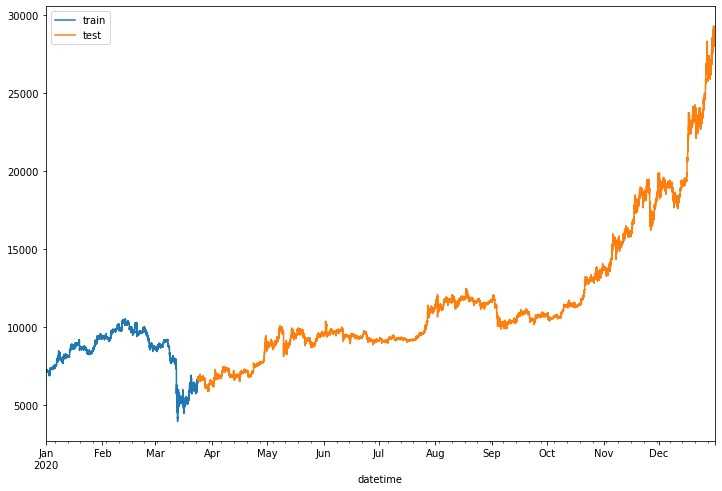

In [99]:
#split into training and testing data
#train_btc = btc_df.loc[:split_date] # (420481, 1)
#test_btc = btc_df.loc[split_date:] # (106560, 1)

train_btc = btc_df.iloc[:120000] # (420481, 1)
test_btc = btc_df.iloc[120000:] # (106560, 1)

print(train_btc.shape)
print(test_btc.shape)

print(type(train_btc))

ax = train_btc.plot(kind='line',figsize=(12,8))
test_btc.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

### Data Normalization

In [100]:
from sklearn.preprocessing import StandardScaler

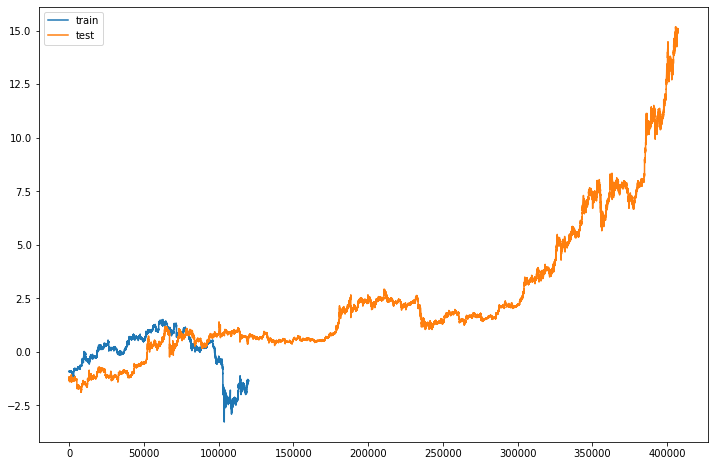

In [101]:
#scale data by subtracting mean and dividing by STD
btc_sc = StandardScaler()

btc_sc.fit_transform(train_btc)

btc_train_sc = btc_sc.fit_transform(train_btc)
btc_test_sc = btc_sc.transform(test_btc)


#btc_train_sc = np.flip(btc_train_sc, axis=0)
#btc_test_sc = np.flip(btc_test_sc, axis=0)

btc_x_train = btc_train_sc[:-1] #(420480, 1)
btc_y_train = btc_train_sc[1:] #(420480, 1)

btc_x_test = btc_test_sc[:-1] #(106559, 1)
btc_y_test = btc_test_sc[1:] #(106559, 1)


df_btc_x_train = pd.DataFrame(btc_x_train)
df_btc_x_test = pd.DataFrame(btc_x_test)

ax = df_btc_x_train.plot(kind='line',figsize=(12,8))
df_btc_x_test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [102]:
btc_x_train_t = btc_x_train.reshape(btc_x_train.shape[0], 1, btc_x_train.shape[1]) # (106559, 1, 1)
btc_x_test_t = btc_x_test.reshape(btc_x_test.shape[0], 1, btc_x_test.shape[1]) # (420480, 1, 1)
btc_x_test_t.shape

(407039, 1, 1)

### GRU

In [103]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, btc_x_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(btc_x_train_t, btc_y_train, epochs=5, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/5
119999/119999 [==============================] - 91s 748us/step - loss: 0.0040 - rmse: 0.0431
Epoch 2/5
119999/119999 [==============================] - 69s 578us/step - loss: 5.8403e-05 - rmse: 0.0075s - loss: 5.818
Epoch 3/5
119999/119999 [==============================] - 74s 616us/step - loss: 5.2184e-05 - rmse: 0.0071
Epoch 4/5
119999/119999 [==============================] - 75s 622us/step - loss: 5.0918e-05 - rmse: 0.0070
Epoch 5/5
119999/119999 [==============================] - 74s 618us/step - loss: 4.9777e-05 - rmse: 0.0069


In [95]:
history_model_gru = model_gru.fit(btc_x_train_t, btc_y_train, epochs=1, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

420480/420480 [==============================] - 341s 812us/step - loss: 1.3133e-04 - rmse: 0.0115


(119999, 1, 1)


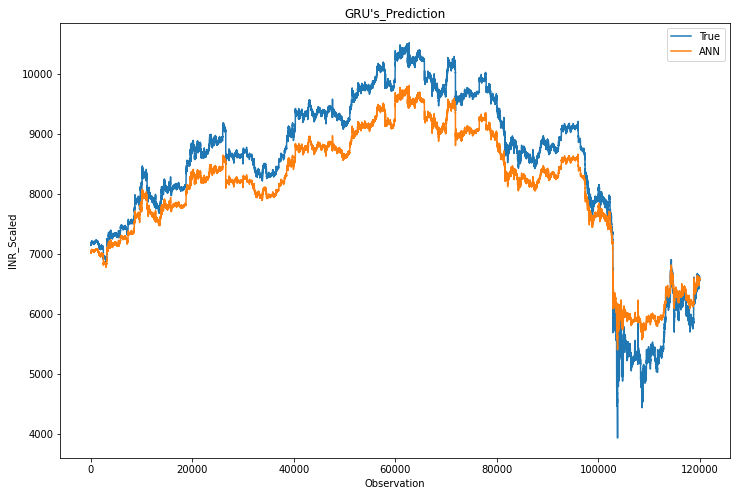

In [123]:
btc_y_train_pred = model_gru.predict(btc_x_train_t)


print(btc_x_train_t.shape)

plt.figure(figsize=(12,8))
plt.plot( btc_sc.inverse_transform(btc_y_train), label='True')
plt.plot( btc_sc.inverse_transform(btc_y_train_pred), label='ANN')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

(407039, 1, 1)


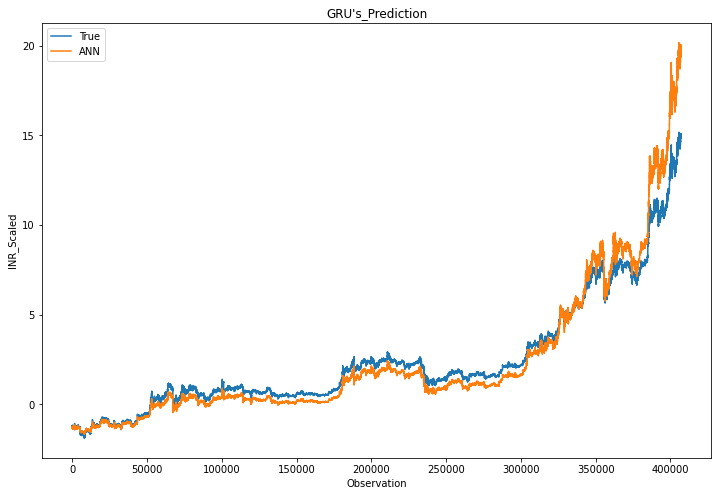

In [124]:
btc_y_test_pred = model_gru.predict(btc_x_test_t)

print(btc_x_test_t.shape)

plt.figure(figsize=(12,8))
plt.plot(btc_y_test, label='True')
plt.plot(btc_y_test_pred, label='ANN')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [107]:
btc_y_test_pred = model.predict(btc_x_test)
btc_y_train_pred = model.predict(btc_x_train)

train_mse = metrics.mean_squared_error(btc_y_train, btc_y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(btc_y_test, btc_y_test_pred)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(btc_y_train, btc_y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(btc_y_train, btc_y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(btc_y_train, btc_y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, btc_x_train.shape[0], btc_x_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(btc_y_test, btc_y_test_pred)))
r2_test = r2_score(btc_y_test, btc_y_test_pred)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, btc_x_test.shape[0], btc_x_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(btc_y_test, btc_y_test_pred)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	-1.159
The  MAE on the Train set is:	1.367
The  RMSE on the Train set is:	1.469
The Adjusted R2 score on the Train set is:	-1.159

The R2 score on the Test set is:	-0.227
The Adjusted R2 score on the Test set is:	-0.227
The  MAE on the Test set is:	2.912
The  RMSE on the Test set is:	3.615


## ETH data

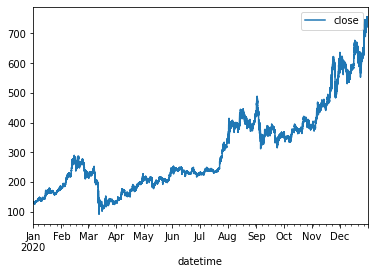

In [119]:
import logging
logging.getLogger().setLevel(level=logging.WARNING)

eth_data = pd.read_csv('ETH-USD.csv')
# set index of dataframe to be datetime column

eth_data["datetime"] = pd.to_datetime(eth_data["datetime"])
ind_eth_data = eth_data.set_index(["datetime"], drop=True)

# sorting the dataset in ascending order of date
eth_data_frame = ind_eth_data.sort_index(axis=1 ,ascending=True)
eth_data_frame.head()

#filter to just closing price
eth_df = eth_data_frame[["close"]]

eth_df.head()


eth_df.plot()


#scale data by subtracting mean and dividing by STD
eth_sc = StandardScaler()

eth_test = eth_sc.fit_transform(eth_df)

eth_test_t = eth_test.reshape(eth_test.shape[0], 1, eth_test.shape[1]) # (106559, 1, 1)



#ax = eth_test_sc.plot(kind='line',figsize=(12,8))
#plt.legend(['test'])

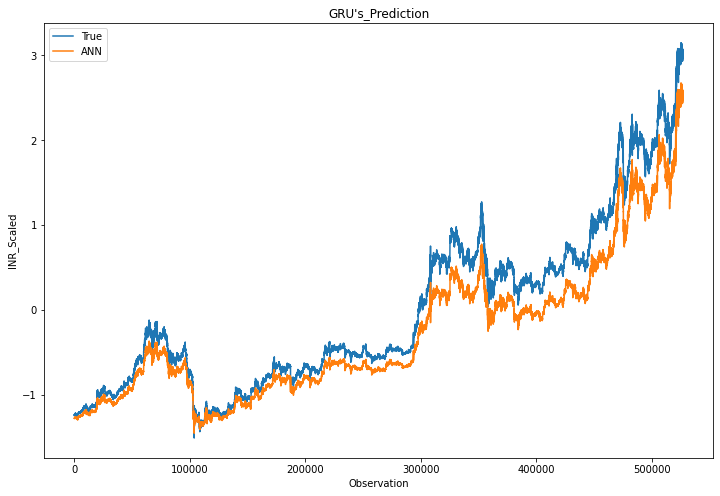

In [121]:
eth_pred = model_gru.predict(eth_test_t)

plt.figure(figsize=(12,8))
plt.plot(eth_test, label='True')
plt.plot(eth_pred, label='ANN')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [122]:
model_gru.save('gru_model')

INFO:tensorflow:Assets written to: gru_model\assets


### Artificial Neural Network

In [11]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(btc_x_train, btc_y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
106559/106559 [==============================] - 38s 353us/step - loss: 3.6571e-04 - rmse: 0.0148
Epoch 2/200
106559/106559 [==============================] - 38s 354us/step - loss: 0.0032 - rmse: 0.0364
Epoch 3/200
106559/106559 [==============================] - 38s 355us/step - loss: 0.0057 - rmse: 0.0484
Epoch 00003: early stopping


### ANN Prediction

In [15]:
btc_y_test_pred = model.predict(btc_x_test)
btc_y_train_pred = model.predict(btc_x_train)

train_mse = metrics.mean_squared_error(btc_y_train, btc_y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(btc_y_test, btc_y_test_pred)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(btc_y_train, btc_y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(btc_y_train, btc_y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(btc_y_train, btc_y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, btc_x_train.shape[0], btc_x_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(btc_y_test, btc_y_test_pred)))
r2_test = r2_score(btc_y_test, btc_y_test_pred)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, btc_x_test.shape[0], btc_x_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(btc_y_test, btc_y_test_pred)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	-1.100
The  MAE on the Train set is:	1.273
The  RMSE on the Train set is:	1.449
The Adjusted R2 score on the Train set is:	-1.100

The R2 score on the Test set is:	-2.017
The Adjusted R2 score on the Test set is:	-2.017
The  MAE on the Test set is:	0.549
The  RMSE on the Test set is:	0.664


### ANN Prediction Plot

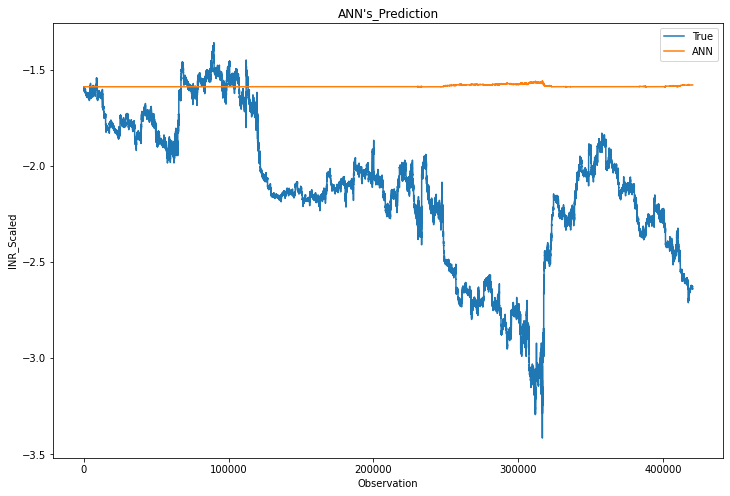

In [16]:
plt.figure(figsize=(12,8))
plt.plot(btc_y_test, label='True')
plt.plot(btc_y_test_pred, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### Data preprocessing for LSTM

### LSTM

In [20]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2086/2086 [==============================] - 5s 2ms/step - loss: 0.3607 - rmse: 0.5155
Epoch 2/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0051 - rmse: 0.0638
Epoch 3/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0031 - rmse: 0.0518
Epoch 4/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0033 - rmse: 0.0535
Epoch 5/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0035 - rmse: 0.0550
Epoch 6/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0034 - rmse: 0.0540
Epoch 7/100
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0033 - rmse: 0.0532
Epoch 8/100
1050/2086 [==============>...............] - ETA: 1s - loss: 0.0043 - rmse: 0.0595

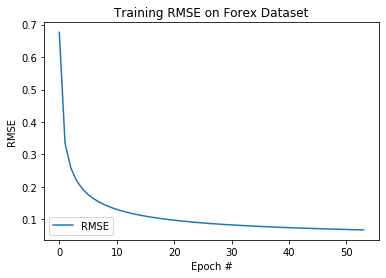

In [53]:
N = 54

plt.figure()



plt.plot(np.arange(0, N), history_model_lstm.history["rmse"], label="RMSE")
plt.title("Training RMSE on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="lower left")

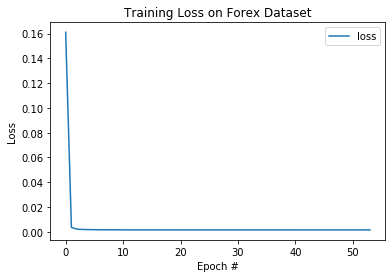

In [54]:
N = 54

plt.figure()



plt.plot(np.arange(0, N), history_model_lstm.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

### LSTM Prediction

In [63]:


y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.977
The  MAE on the Train set is:	0.132
The  RMSE on the Train set is:	0.151
The Adjusted R2 score on the Train set is:	0.977

The R2 score on the Test set is:	0.879
The Adjusted R2 score on the Test set is:	0.879
The  MAE on the Test set is:	0.075
The  RMSE on the Test set is:	0.102


### LSTM Prediction Plot

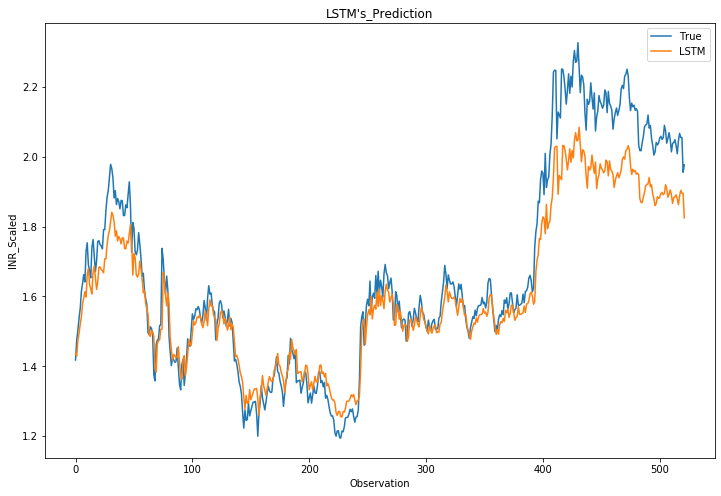

In [64]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [49]:
X_tr_t.shape

(106559, 1, 1)

## PROTECT THE MODEL

In [50]:
model_gru.save('model_gru_btc/')

INFO:tensorflow:Assets written to: models/assets


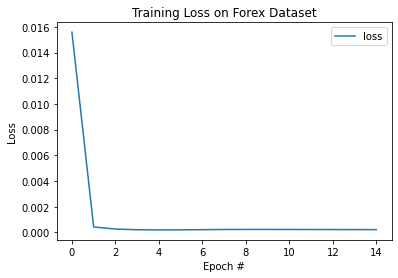

In [29]:
N = 15

plt.figure()



plt.plot(np.arange(0, N), history_model_gru.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

### GRU Prediction

In [30]:


y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.796
The  MAE on the Train set is:	0.320
The  RMSE on the Train set is:	0.452
The Adjusted R2 score on the Train set is:	0.796

The R2 score on the Test set is:	0.997
The Adjusted R2 score on the Test set is:	0.997
The  MAE on the Test set is:	0.011
The  RMSE on the Test set is:	0.020


In [114]:
X_tr_t.shape

(106559, 1, 1)

### GRU Prediction Plot

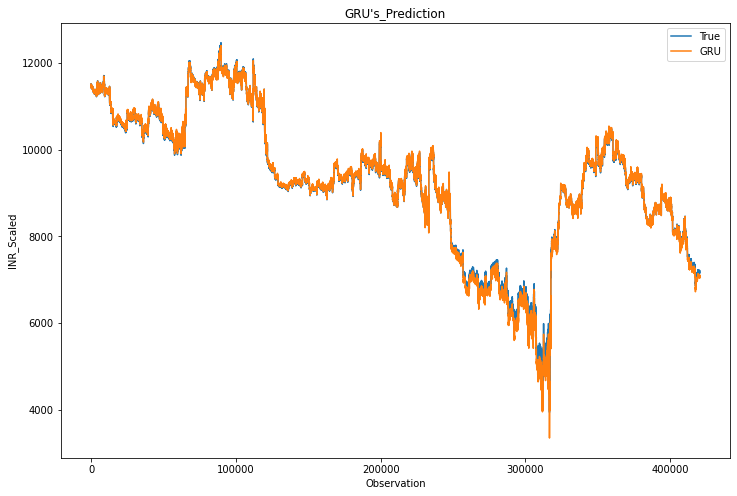

In [132]:
plt.figure(figsize=(12,8))
plt.plot(sc.inverse_transform(y_test), label='True')
plt.plot(sc.inverse_transform(y_pred_test_gru), label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## output values

In [33]:
inv_yhat = sc.inverse_transform(y_pred_test_gru)

inv_yhat

array([[11512.699 ],
       [11510.455 ],
       [11501.779 ],
       ...,
       [ 7055.2925],
       [ 7051.9136],
       [ 7047.733 ]], dtype=float32)

In [58]:
inv_ytest = sc.inverse_transform(y_test)

inv_ytest.shape

X_tr_t

array([[[ 2.62037383]],

       [[ 2.62016664]],

       [[ 2.63165566]],

       ...,

       [[-1.58642459]],

       [[-1.58352885]],

       [[-1.58714491]]])

## testing on ethereum

In [82]:
#new_data = [
#    [[2.6784]],
#    [[2.67578]],
#    [[2.78943534]]
#]

#shape (3,)
new_data = np.array([
    13356.067,
    13355.089,
    13367.078
])

#shape (3,1)
new_data = np.expand_dims(new_data, axis=1)

new_data = sc.transform(new_data)

print(new_data.shape)

# shape 3,1,1
new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])

print(new_data.shape)

out = model_gru.predict(new_data)


sc.inverse_transform(out)

(3, 1)
(3, 1, 1)


array([[13203.725],
       [13202.855],
       [13213.505]], dtype=float32)

In [88]:
eth_data = cb_obj.get_market_data('ETH-USD', start_date, end_date, interval=60)
eth_data.head()

Getting ETH-USD data from 20200101 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=366)

Completed in 4.77 seconds


,timestamp,low,high,open,close,volume,datetime,product,date
0,1577836800,128.41,128.54,128.54,128.41,45.547828,2020-01-01 00:00:00+00:00,ETH-USD,20200101
1,1577836860,128.40,128.41,128.41,128.41,6.623134,2020-01-01 00:01:00+00:00,ETH-USD,20200101
2,1577836920,128.35,128.41,128.40,128.35,41.532319,2020-01-01 00:02:00+00:00,ETH-USD,20200101
3,1577836980,128.35,128.41,128.35,128.39,31.112647,2020-01-01 00:03:00+00:00,ETH-USD,20200101
4,1577837040,128.35,128.41,128.38,128.35,36.884010,2020-01-01 00:04:00+00:00,ETH-USD,20200101


In [90]:
ind_eth_data = eth_data.set_index(["datetime"], drop=True)
ind_eth_data.head()

,timestamp,low,high,open,close,volume,product,date
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,1577836800,128.41,128.54,128.54,128.41,45.547828,ETH-USD,20200101
2020-01-01 00:01:00+00:00,1577836860,128.40,128.41,128.41,128.41,6.623134,ETH-USD,20200101
2020-01-01 00:02:00+00:00,1577836920,128.35,128.41,128.40,128.35,41.532319,ETH-USD,20200101
2020-01-01 00:03:00+00:00,1577836980,128.35,128.41,128.35,128.39,31.112647,ETH-USD,20200101
2020-01-01 00:04:00+00:00,1577837040,128.35,128.41,128.38,128.35,36.884010,ETH-USD,20200101


In [98]:
# sorting the dataset in ascending order of date
data_frame = ind_eth_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,close,date,high,low,open,product,timestamp,volume
datetime,,,,,,,,
2020-12-31 23:59:00+00:00,737.67,20201231,738.17,737.11,737.37,ETH-USD,1609459140,61.741184
2020-12-31 23:58:00+00:00,737.40,20201231,738.67,737.40,738.67,ETH-USD,1609459080,248.566295
2020-12-31 23:57:00+00:00,738.66,20201231,738.86,738.08,738.20,ETH-USD,1609459020,176.676540
2020-12-31 23:56:00+00:00,738.09,20201231,738.92,738.02,738.58,ETH-USD,1609458960,52.702150
2020-12-31 23:55:00+00:00,738.58,20201231,738.99,738.41,738.41,ETH-USD,1609458900,27.373506


(527040, 1)


<AxesSubplot:xlabel='datetime'>

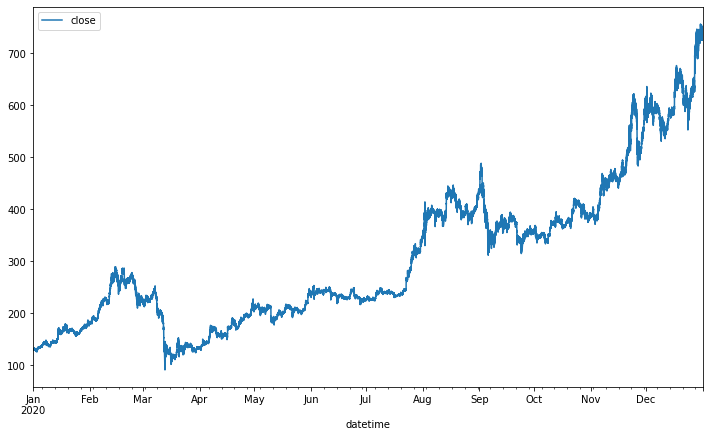

In [101]:
df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years
print(df.shape)
df.plot(kind='line',figsize=(12,7))

In [118]:
sc_eth = StandardScaler()
eth_in = sc_eth.fit_transform(df)

eth_in = eth_in.reshape(eth_in.shape[0], 1, eth_in.shape[1])
eth_in.shape

(527040, 1, 1)

In [119]:
eth_out = model_gru.predict(eth_in)
eth_out

array([[ 1.3847504],
       [ 1.3840532],
       [ 1.3873043],
       ...,
       [-1.2695191],
       [-1.269141 ],
       [-1.269141 ]], dtype=float32)

In [123]:
eth_out_scaled= sc_eth.inverse_transform(eth_out)
print(eth_out_scaled.shape)
print(df.shape)

(527040, 1)
(527040, 1)


In [117]:
df

,close
datetime,
2020-12-31 23:59:00+00:00,737.67
2020-12-31 23:58:00+00:00,737.40
2020-12-31 23:57:00+00:00,738.66
2020-12-31 23:56:00+00:00,738.09
2020-12-31 23:55:00+00:00,738.58
...,...
2020-01-01 00:04:00+00:00,128.35
2020-01-01 00:03:00+00:00,128.39
2020-01-01 00:02:00+00:00,128.35


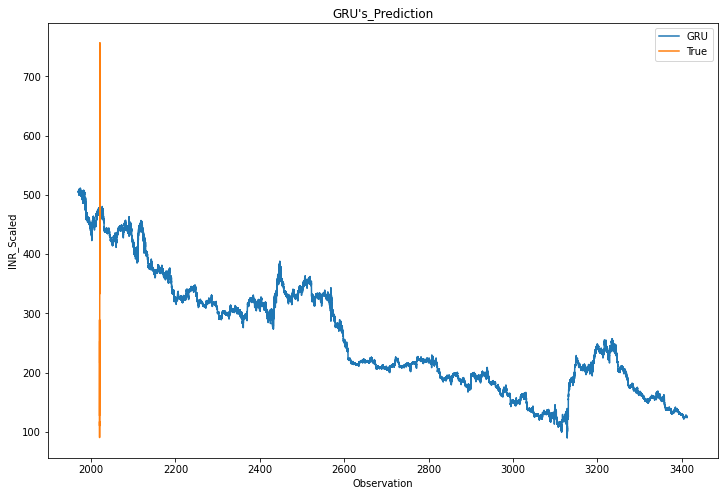

In [131]:
plt.figure(figsize=(12,8))
plt.plot(eth_out_scaled, label='GRU')
plt.plot(df, label='True')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

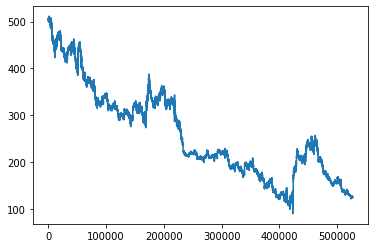

In [125]:
plt.figure(figsize=(12,8))

In [36]:
test_mse = metrics.mean_squared_error(inv_ytest, inv_yhat)
rmse_test = np.sqrt(test_mse)


print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(inv_ytest, inv_yhat)))
r2_test = r2_score(inv_ytest, inv_yhat)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(inv_ytest, inv_yhat)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Test set is:	0.997
The Adjusted R2 score on the Test set is:	0.997
The  MAE on the Test set is:	47.545
The  RMSE on the Test set is:	81.780


In [37]:
test.head()

,close
datetime,
2020-10-19 00:00:00+00:00,11516.56
2020-10-18 23:59:00+00:00,11514.20
2020-10-18 23:58:00+00:00,11505.07
2020-10-18 23:57:00+00:00,11510.83
2020-10-18 23:56:00+00:00,11515.90


In [39]:
col1 = pd.DataFrame(inv_ytest, columns=['Price'])

col2 = pd.DataFrame(inv_yhat, columns=['GRU_prediction'])

col3 = pd.DataFrame(history_model_gru.history['rmse'], columns=['RMSE'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_csv('Prediction_USD_INR_GRU.xlsx')

In [40]:
results.head()

,Price,GRU_prediction,RMSE
0,11514.20,11512.699219,0.124806
1,11505.07,11510.455078,0.020547
2,11510.83,11501.779297,0.016225
3,11515.90,11507.253906,0.014421
4,11519.26,11512.071289,0.013917


In [41]:
results[:1000]

,Price,GRU_prediction,RMSE
0,11514.20,11512.699219,0.124806
1,11505.07,11510.455078,0.020547
2,11510.83,11501.779297,0.016225
3,11515.90,11507.253906,0.014421
4,11519.26,11512.071289,0.013917
...,...,...,...
995,11449.00,11450.943359,NaN
996,11449.70,11448.428711,NaN
997,11449.27,11449.096680,NaN
998,11448.12,11448.685547,NaN


In [42]:
test.reset_index(level=0, inplace=True)
test.head()

,datetime,close
0,2020-10-19 00:00:00+00:00,11516.56
1,2020-10-18 23:59:00+00:00,11514.20
2,2020-10-18 23:58:00+00:00,11505.07
3,2020-10-18 23:57:00+00:00,11510.83
4,2020-10-18 23:56:00+00:00,11515.90


In [44]:
dfinal = test.merge(results, how='inner', left_on='Price', right_on='Price')

MergeError: Must pass "right_on" OR "right_index".

In [179]:
dfinal.drop_duplicates(subset="Date",inplace=True)


dfinal.head()

,Date,Price,GRU_prediction,RMSE
0,2018-08-28,70.100,70.279488,1.520728
1,2018-08-29,70.535,70.222733,0.763046
3,2019-02-12,70.535,70.222733,0.763046
5,2018-08-30,70.745,70.602669,0.587125
7,2019-10-28,70.745,70.602669,0.587125


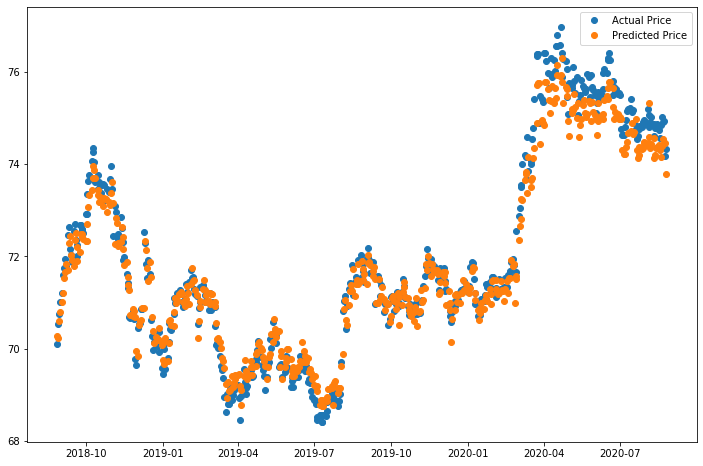

In [180]:
plt.figure(figsize=(12,8))
price_date = dfinal['Date']
price_true = dfinal['Price']
price_pred = dfinal['GRU_prediction']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [182]:
dfinal.describe()

,Price,GRU_prediction,RMSE
count,522.000000,522.000000,112.000000
mean,71.974153,71.857010,0.195136
std,2.230849,1.973050,0.176829
min,68.410000,68.746681,0.100566
25%,70.514250,70.502197,0.115272
50%,71.345000,71.282589,0.135314
75%,73.681500,73.351963,0.195743
max,76.975000,76.288742,1.520728
